In [1]:
import torch
import torch.nn.functional as F
import time
import random
import re
from collections import defaultdict
from transformers import AutoTokenizer
from model.modeling_llada import LLaDAModelLM
from generate import generate_with_dual_cache

/home/pianng/miniconda3/envs/dllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载模型
device = 'cuda'
model = LLaDAModelLM.from_pretrained('GSAI-ML/LLaDA-8B-Instruct', torch_dtype=torch.bfloat16).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained('GSAI-ML/LLaDA-8B-Instruct')

Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00,  7.11it/s]


In [3]:
# ===== Hidden States Wrapper =====
class HiddenStatesTracer:
    """用 hook 抓取每层 hidden states，不修改模型内部代码"""
    
    def __init__(self, model):
        self.model = model
        self.hidden_states = {}  # {layer_idx: tensor}
        self.hooks = []
        self.step_traces = []  # 保存每个 step 的 hidden states
        
    def _make_hook(self, layer_idx):
        def hook(module, input, output):
            # output 是 (hidden_state, cache) tuple
            if isinstance(output, tuple):
                self.hidden_states[layer_idx] = output[0].detach().clone()
            else:
                self.hidden_states[layer_idx] = output.detach().clone()
        return hook
    
    def register_hooks(self):
        """注册 hooks 到每个 transformer block"""
        blocks = self.model.model.transformer.blocks
        for idx, block in enumerate(blocks):
            hook = block.register_forward_hook(self._make_hook(idx))
            self.hooks.append(hook)
        print(f"Registered hooks on {len(blocks)} layers")
    
    def remove_hooks(self):
        """移除所有 hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def save_step(self):
        """保存当前 step 的 hidden states"""
        self.step_traces.append({k: v.clone() for k, v in self.hidden_states.items()})
    
    def clear(self):
        """清空记录"""
        self.hidden_states = {}
        self.step_traces = []
    
    def get_traces(self):
        """返回所有 step 的 traces"""
        return self.step_traces

In [4]:
# ===== 带 trace 的生成函数 =====
def generate_with_trace(model, tracer, prompt, steps=128, gen_length=128, block_length=32, threshold=0.9, mask_id=126336):
    """
    在 generate_with_dual_cache 基础上，每个 step 保存 hidden states
    """
    from generate import get_num_transfer_tokens, get_transfer_index, get_transfer_index_dynamic
    
    B = prompt.shape[0]
    Lp = int(prompt.shape[1])
    num_blocks = gen_length // block_length
    steps_per_block = steps // num_blocks
    
    x = torch.full((B, Lp + gen_length), mask_id, dtype=torch.long, device=model.device)
    x[:, :Lp] = prompt
    
    tracer.clear()
    nfe = 0
    
    for nb in range(num_blocks):
        s = Lp + nb * block_length
        e = s + block_length
        
        block_mask_index = (x[:, s:e] == mask_id)
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps_per_block)
        
        # Step 0: 完整前向
        out_full = model(x, use_cache=True)
        past_key_values = out_full.past_key_values
        tracer.save_step()  # 保存 hidden states
        nfe += 1
        
        replace_position = torch.zeros_like(x, dtype=torch.bool)
        replace_position[:, s:e] = True
        
        global_mask_index = (x == mask_id)
        global_mask_index[:, e:] = False
        
        quota0 = None if threshold is not None else num_transfer_tokens[:, 0]
        x0, transfer_index = get_transfer_index(
            out_full.logits, 0., "low_confidence", global_mask_index, x, quota0, threshold
        )
        x = torch.where(transfer_index, x0, x)
        
        # Step 1~N
        for i in range(1, steps_per_block):
            if (x[:, s:e] == mask_id).sum() == 0:
                break
            
            logits_blk = model(
                x[:, s:e], past_key_values=past_key_values, use_cache=True, replace_position=replace_position
            ).logits
            tracer.save_step()  # 保存 hidden states
            nfe += 1
            
            mask_blk = (x[:, s:e] == mask_id)
            quota_i = None if threshold is not None else num_transfer_tokens[:, i]
            x0_blk, transfer_idx_blk = get_transfer_index(
                logits_blk, 0., "low_confidence", mask_blk, x[:, s:e], quota_i, threshold
            )
            
            blk_old = x[:, s:e]
            blk_new = torch.where(transfer_idx_blk, x0_blk, blk_old)
            x = torch.cat([x[:, :s], blk_new, x[:, e:]], dim=1)
    
    return x, nfe, tracer.get_traces()

In [5]:
# ===== 计算 step 之间的 cosine similarity =====
def compute_layer_cos_sim(traces, layer_idx, pos_start, pos_end):
    """
    计算指定 layer 在连续 step 之间的 cosine similarity
    
    Args:
        traces: list of {layer_idx: tensor}
        layer_idx: 要分析的层
        pos_start, pos_end: 位置范围（当前 block 的位置）
    
    Returns:
        cos_sims: list of (step_i, step_i+1) 之间每个 token 的 cos sim
    """
    cos_sims = []
    for i in range(len(traces) - 1):
        if layer_idx not in traces[i] or layer_idx not in traces[i+1]:
            continue
        h1 = traces[i][layer_idx][:, pos_start:pos_end, :]  # (B, L, D)
        h2 = traces[i+1][layer_idx][:, pos_start:pos_end, :]
        
        # 如果维度不匹配（部分计算），跳过
        if h1.shape != h2.shape:
            continue
        
        cos = F.cosine_similarity(h1.float(), h2.float(), dim=-1)  # (B, L)
        cos_sims.append(cos.mean().item())  # 取平均
    return cos_sims

In [6]:
# ===== 加载 GSM8K =====
from datasets import load_dataset

random.seed(42)
gsm8k = load_dataset("openai/gsm8k", "main", split="test")
gsm8k_30 = random.sample(list(gsm8k), 15)

In [7]:
# ===== 注册 hooks =====
tracer = HiddenStatesTracer(model)
tracer.register_hooks()

Registered hooks on 32 layers


In [9]:
# ===== 跑 1 个样本测试 =====
item = gsm8k_30[0]
question = item['question']

m = [{"role": "user", "content": question}]
text = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = torch.tensor(tokenizer(text)['input_ids']).to(device).unsqueeze(0)

print(f"Input length: {input_ids.shape[1]}")    

out, nfe, traces = generate_with_trace(model, tracer, input_ids, steps=32, gen_length=64, block_length=32, threshold=0.9)
print(f"NFE: {nfe}, Traces: {len(traces)} steps")
print(f"Each trace has {len(traces[0])} layers")

Input length: 74
NFE: 26, Traces: 26 steps
Each trace has 32 layers


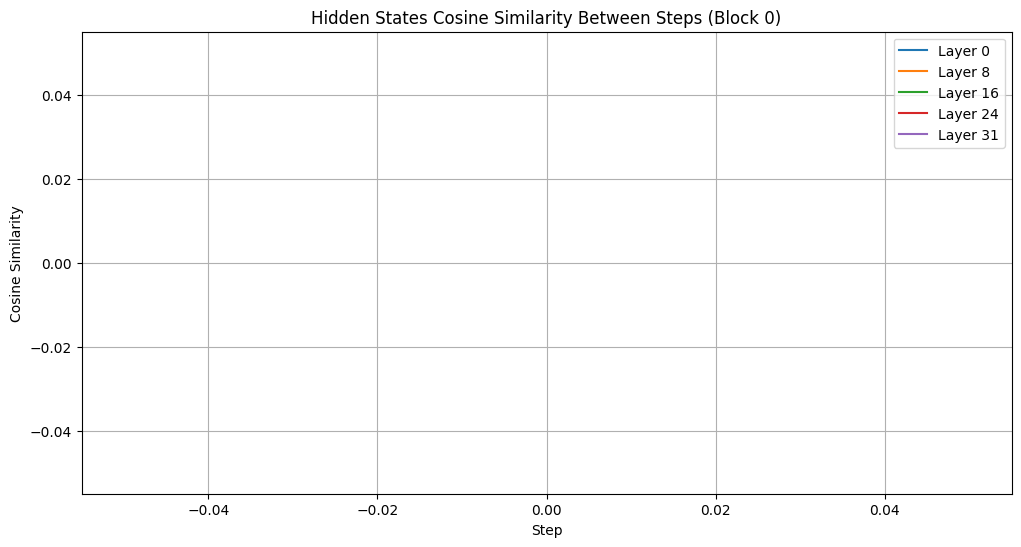

In [10]:
# ===== 分析：不同 layer 的 step 间 cosine similarity =====
import matplotlib.pyplot as plt

Lp = input_ids.shape[1]
block_length = 32

# 分析第一个 block (位置 Lp 到 Lp+32)
pos_start, pos_end = Lp, Lp + block_length

# 选几个 layer 来分析
layers_to_analyze = [0, 8, 16, 24, 31]

plt.figure(figsize=(12, 6))
for layer_idx in layers_to_analyze:
    cos_sims = compute_layer_cos_sim(traces, layer_idx, pos_start, pos_end)
    if cos_sims:
        plt.plot(cos_sims, label=f'Layer {layer_idx}')

plt.xlabel('Step')
plt.ylabel('Cosine Similarity')
plt.title('Hidden States Cosine Similarity Between Steps (Block 0)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ===== 统计 30 题的平均 cos sim =====
all_layer_cos_sims = defaultdict(list)  # {layer_idx: [cos_sim_per_sample]}

for i, item in enumerate(gsm8k_30[:5]):  # 先跑 5 个测试
    question = item['question']
    m = [{"role": "user", "content": question}]
    text = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
    input_ids = torch.tensor(tokenizer(text)['input_ids']).to(device).unsqueeze(0)
    
    out, nfe, traces = generate_with_trace(model, tracer, input_ids, steps=128, gen_length=128, block_length=32, threshold=0.9)
    
    Lp = input_ids.shape[1]
    pos_start, pos_end = Lp, Lp + 32
    
    for layer_idx in range(32):
        cos_sims = compute_layer_cos_sim(traces, layer_idx, pos_start, pos_end)
        if cos_sims:
            all_layer_cos_sims[layer_idx].append(sum(cos_sims) / len(cos_sims))
    
    print(f"[{i+1}/5] done")

# 打印每层的平均 cos sim
print("\nLayer-wise average cosine similarity:")
for layer_idx in range(32):
    if all_layer_cos_sims[layer_idx]:
        avg = sum(all_layer_cos_sims[layer_idx]) / len(all_layer_cos_sims[layer_idx])
        print(f"Layer {layer_idx:2d}: {avg:.4f}")

In [1]:
# ===== 清理 hooks =====
tracer.remove_hooks()

NameError: name 'tracer' is not defined